In [1]:
import pandas as pd

In [2]:
df_subset = pd.read_excel('Online Retail.xlsx', nrows = 2000)
df_subset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df_subset.shape

(2000, 8)

In [5]:
# Check for missing values in each column
missing_values_count = df_subset.isnull().sum()

# Check for duplicate rows
duplicate_rows_count = df_subset.duplicated().sum()

missing_values_count, duplicate_rows_count

(InvoiceNo        0
 StockCode        0
 Description      6
 Quantity         0
 InvoiceDate      0
 UnitPrice        0
 CustomerID     533
 Country          0
 dtype: int64,
 36)

In [6]:
# Remove missing values
df_subset_cleaned = df_subset.dropna(subset=['Description', 'CustomerID'])

# Remove duplicate rows
df_subset_cleaned = df_subset_cleaned.drop_duplicates()

# Check the shape of the cleaned data
df_subset_cleaned.shape

(1431, 8)

In [7]:
import numpy as np

# Convert InvoiceDate to datetime type if it's not
df_subset_cleaned['InvoiceDate'] = pd.to_datetime(df_subset_cleaned['InvoiceDate'])

# Create a Monetary Value column
df_subset_cleaned['MonetaryValue'] = df_subset_cleaned['Quantity'] * df_subset_cleaned['UnitPrice']

# Calculate RFM metrics
rfm_df = df_subset_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df_subset_cleaned['InvoiceDate'].max() - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'MonetaryValue': 'sum'  # Monetary Value
})

# Rename the columns
rfm_df.rename(columns={'InvoiceDate': 'Recency',
                       'InvoiceNo': 'Frequency',
                       'MonetaryValue': 'MonetaryValue'}, inplace=True)

# Show a preview of the RFM DataFrame
rfm_df.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12431.0,0,1,358.25
12433.0,0,1,1919.14
12472.0,0,1,-122.30
12583.0,0,1,855.86
12662.0,0,1,261.48


In [8]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the RFM data
rfm_normalized = scaler.fit_transform(rfm_df)

# Convert the numpy array back to a DataFrame for better readability
rfm_normalized_df = pd.DataFrame(rfm_normalized, index=rfm_df.index, columns=rfm_df.columns)

# Show a preview of the normalized RFM DataFrame
rfm_normalized_df.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12431.0,0.0,-0.224231,-0.150422
12433.0,0.0,-0.224231,2.512257
12472.0,0.0,-0.224231,-0.970179
12583.0,0.0,-0.224231,0.698437
12662.0,0.0,-0.224231,-0.315499


/Users/macbookpro/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/macbookpro/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/macbookpro/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/macbookpro/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


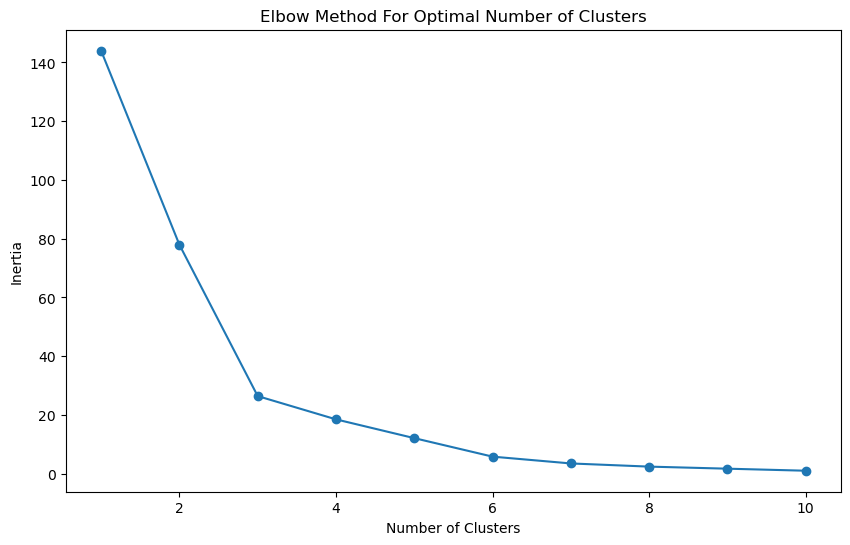

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow Method
inertia = []
range_values = range(1, 11)

for i in range_values:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(rfm_normalized_df)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range_values, inertia, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [10]:
# Apply K-Means algorithm with the optimal number of clusters (3 in this case)
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(rfm_normalized_df)

# Assign the clusters to the original normalized data
rfm_normalized_df['Cluster'] = kmeans.labels_

# Assign the clusters to the original (non-normalized) data for interpretation
rfm_df['Cluster'] = kmeans.labels_

# Show a preview of the data with cluster assignments
rfm_df.head()

/Users/macbookpro/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12431.0,0,1,358.25,0
12433.0,0,1,1919.14,2
12472.0,0,1,-122.30,0
12583.0,0,1,855.86,0
12662.0,0,1,261.48,0


In [11]:
# Calculate average RFM values for each cluster
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).reset_index()

# Rename columns for easier interpretation
cluster_summary.columns = ['Cluster', 'Avg_Recency', 'Avg_Frequency', 'Avg_MonetaryValue', 'Customer_Count']

cluster_summary

,Cluster,Avg_Recency,Avg_Frequency,Avg_MonetaryValue,Customer_Count
0,0,0.0,1.119403,309.280597,67
1,1,0.0,10.000000,1499.340000,1
2,2,0.0,1.250000,2480.435000,4


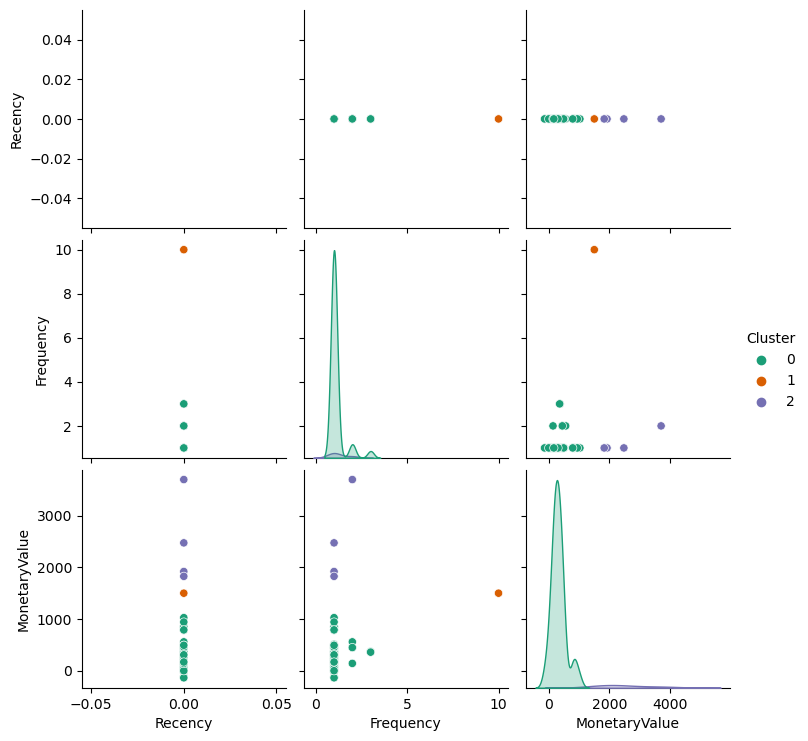

In [12]:
import seaborn as sns

# Visualizing the clusters using pairplot
sns.pairplot(data=rfm_df, hue='Cluster', palette='Dark2', diag_kind='kde')
plt.show()